#### Learning the autocorrelation of signals using SGD

In [ ]:
import tensorflow as tf
import timesynth as ts
import numpy as np
from tqdm import tqdm
import sys
sys.path.append('/Users/abhishek/Projects/experimental-timeflow/')
import timeflow as tflow
import matplotlib.pylab as plt
import statsmodels.api as sm
%matplotlib inline

In [ ]:
def generate_data(phi, sigma, num_points):
    time_sampler = ts.TimeSampler(stop_time=100)
    irregular_time_samples = time_sampler.sample_irregular_time(num_points=num_points,
                                                                keep_percentage=50)
    irregular_time_samples_diff = np.diff(irregular_time_samples)
    signal = np.zeros(len(irregular_time_samples))
    noise_samples = np.random.normal(loc=0, scale=1., size=len(irregular_time_samples))
    for i in range(len(irregular_time_samples_diff)):
        signal[i+1] = phi**irregular_time_samples_diff[i]* signal[i] + \
                        sigma*np.sqrt(1.0 - phi**(2*irregular_time_samples_diff[i]))*noise_samples[i]
    return irregular_time_samples, irregular_time_samples_diff, signal

In [3]:
phi = 0.1
sigma = 0.3
num_points = 500

In [4]:
time_vector, time_diff, signal = generate_data(phi, sigma, num_points)

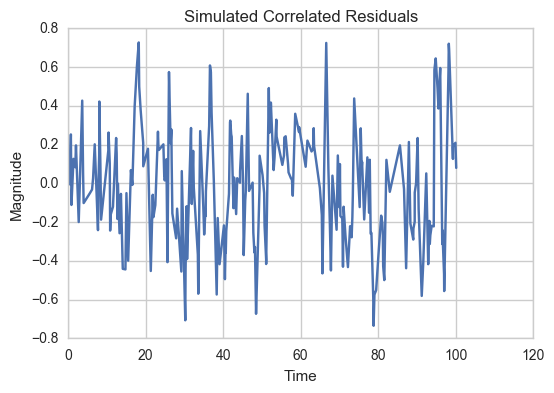

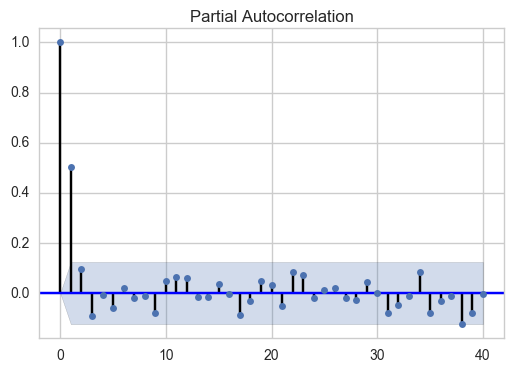

In [5]:
plt.plot(time_vector, signal)
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Simulated Correlated Residuals')
sm.graphics.tsa.plot_pacf(signal, lags=40);

In [6]:
#Calculating the log-likelihood
def calc_log_loss(phi, sigma, time_diff, signal_):
    log_loss = []
    for i in range(len(time_diff)):
        delta_t = time_diff[i]
        nu = sigma * np.sqrt(1 - phi**(2*delta_t))
        e = (phi**delta_t)*signal_[i] - signal_[i+1]
        log_lik = np.log(2.51*nu) + np.divide(e**2, 2*nu**2)
        log_loss.append(log_lik)
    return np.sum(log_loss)

In [7]:
log_loss = calc_log_loss( 0.1, 0.3, time_diff, signal)

In [8]:
print "Calculated log loss :", log_loss

Calculated log loss : -18.9826006854


In [9]:
# Generating the time_difference vector
# time_difference = np.concatenate(([time_vector[0]], np.diff(time_vector)), axis=0)
# Converting into two dimension vectors
# signal = np.reshape(signal, (len(signal), 1))
# time_difference = np.reshape(time_difference, (len(time_difference), 1))

#### SGD solver

In [10]:
time_diff_vector = np.reshape(time_diff, (len(time_diff), 1))

In [11]:
# Transforming the signal into pairs of signal[i], signal[i-1] for every i
signal = np.reshape(signal, (len(signal), 1))
signal_vector = np.concatenate((signal[1:], signal[:-1]), axis=1)

In [12]:
# Initializing the input placeholders
delta_time_input = tf.placeholder(tf.float32, shape=[None, 1], name='delta_t')
signal_input = tf.placeholder(tf.float32, shape=[None, 2], name='signal')

In [13]:
## Testing the new file in TimeFlow
auto_corr_obj = tflow.utils.AutoCorrEstimator(delta_time_input, signal_input)

In [14]:
##Optimizing the value
phi_est, sigma_est = auto_corr_obj.minimize_log_loss(time_diff_vector, signal_vector)

In [15]:
phi_est, sigma_est

(0.10878528, 0.29968286)

In [17]:
signal_vector

array([[ -5.04621583e-03,   0.00000000e+00],
       [  2.52372094e-01,  -5.04621583e-03],
       [ -1.11521802e-01,   2.52372094e-01],
       [  1.26417245e-01,  -1.11521802e-01],
       [  8.31163322e-02,   1.26417245e-01],
       [  1.95934895e-01,   8.31163322e-02],
       [ -1.99754397e-01,   1.95934895e-01],
       [  4.26856429e-01,  -1.99754397e-01],
       [  5.15813952e-02,   4.26856429e-01],
       [ -1.01909492e-01,   5.15813952e-02],
       [ -4.92011462e-02,  -1.01909492e-01],
       [ -3.17929977e-02,  -4.92011462e-02],
       [  2.64992152e-02,  -3.17929977e-02],
       [  2.01447041e-01,   2.64992152e-02],
       [ -2.41612110e-01,   2.01447041e-01],
       [  1.24988918e-02,  -2.41612110e-01],
       [  1.43387613e-01,   1.24988918e-02],
       [  4.22165728e-01,   1.43387613e-01],
       [  8.89137869e-02,   4.22165728e-01],
       [ -1.31979063e-01,   8.89137869e-02],
       [ -1.87516514e-01,  -1.31979063e-01],
       [  1.69187589e-01,  -1.87516514e-01],
       [  

In [ ]:
class ACGraph():
    
    def __init__(self, time_input, signal_input):
        self.time_input = time_input
        self.signal_input = signal_input
        with tf.variable_scope('phi'):
            self.phi_tf = tf.Variable(tf.truncated_normal([1], mean=0.5, stddev=.01))
        with tf.variable_scope('sigma'):
            self.sigma_tf = tf.Variable(tf.truncated_normal([1], mean=0.5, stddev=.01))
        self.next_signal, self.prev_signal = tf.unpack(self.signal_input, axis=1)
        # Extending the dimensions of both the vectors
        self.next_signal = tf.expand_dims(self.next_signal, axis=1)
        self.prev_signal = tf.expand_dims(self.prev_signal, axis=1)
        # Packing all the three tensors for computation
        self.input_ = tf.pack([self.time_input, self.next_signal, self.prev_signal], axis=2)
        
    def generate_log_loss_(self, inputs):
        # Computing the /nu value for all points
        delta_t, next_signal, prev_signal = tf.unpack(inputs, axis=1)
        nu = tf.mul(self.sigma_tf, tf.sqrt(tf.sub(1., tf.pow(self.phi_tf, tf.mul(2., delta_t)))))
        e = tf.sub(tf.mul(tf.pow(self.phi_tf, delta_t), prev_signal), next_signal)
        nu_sq = tf.pow(nu, 2.)
        e_sq = tf.pow(e, 2.)
        # Calculating one step of LL
        log_lik = tf.log(tf.mul(2.51, nu)) + tf.div(e_sq, tf.mul(2., nu_sq))
        return log_lik
    
    def generate_log_loss(self):
        output = tf.map_fn(self.generate_log_loss_, self.input_)
        # Summing over all time points
        return tf.reduce_sum(output)
    
    def generate_log_loss_vectorized(self):
        nu = tf.mul(self.sigma_tf, tf.sqrt(tf.sub(1., tf.pow(self.phi_tf, tf.mul(2., self.time_input)))))
        e = tf.sub(tf.mul(tf.pow(self.phi_tf, self.time_input), self.prev_signal), self.next_signal)
        nu_sq = tf.pow(nu, 2.)
        e_sq = tf.pow(e, 2.)
        # Calculating all steps of LL
        log_lik = tf.log(tf.mul(2.51, nu)) + tf.div(e_sq, tf.mul(2., nu_sq))
        return tf.reduce_sum(log_lik)

In [ ]:
graph_obj = ACGraph(delta_time_input, signal_input)

In [ ]:
log_likelihood = graph_obj.generate_log_loss_vectorized()

In [ ]:
# Training step to reduce log-likelihood
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.0001).minimize(log_likelihood)

In [ ]:
tf.summary.scalar("LL", log_likelihood)
summary_op = tf.summary.merge_all()

In [ ]:
# Starting tensorflow session
sess=tf.InteractiveSession()
tf.global_variables_initializer().run()

In [ ]:
sess.run(log_likelihood, 
         feed_dict={delta_time_input:time_diff_vector,
                    signal_input:signal_vector})

In [ ]:
for k in range(50):
    _, score = sess.run([train_step, log_likelihood],
                         feed_dict={delta_time_input:time_diff_vector,
                                    signal_input:signal_vector})
    phi_value, sigma_value = sess.run([graph_obj.phi_tf[0], graph_obj.sigma_tf[0]])
    print "Phi: %.6f   Sigma: %.6f  LogLikelihood: %.3f " %(phi_value, sigma_value, score)

In [ ]:
#Setting up log directory for tensorboard
logs_path = '../tmp/sgd_corr/1'
writer = tf.train.SummaryWriter(logs_path, graph=tf.get_default_graph())